This Notebook has been divided into two parts.
In the first part Transfer learning is implemented using Xception Model
In the Second part transfer learning is implemented using ResNet

**Note: If you want to run this Notebook or want to implement the same architecture following this Notebook, I would recommend you to use Google Colab and get the `24GB RAM` access `[It is free, you can search online to get some guidance]`.Also don't forget to read the readme.txt.**

#Using Xception Model

##Preprocessing
- Download the dataset
  In this case the data was in a zipped files and the image were  grouped together in different folders.So ,I had to unzip the file and then retrieve images from each folder.
- Split the data into train,test and validation sets.
- Visualizing some training Examples
- Resizing the images. As Xception,ResNet model's input layer accepts 299x299,224x224 pixel images respectively .

In [0]:
!wget 'https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip'

In [0]:
!unzip dogImages.zip

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
  data = load_files(path)
  dog_files = np.array(data['filenames'])
  dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
  return dog_files, dog_targets



Using TensorFlow backend.


In [0]:
#Create Train,Test and Validation sets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')


In [3]:
# load ordered list of dog names
dog_names = [item[25:-1] for item in glob('dogImages/train/*/')]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % str(len(train_files) + len(valid_files) + len(test_files)))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))
print('There are total {0} dog breeds'.format(len(dog_names)))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.
There are total 133 dog breeds


In [0]:
import matplotlib.pyplot as plt
import cv2 

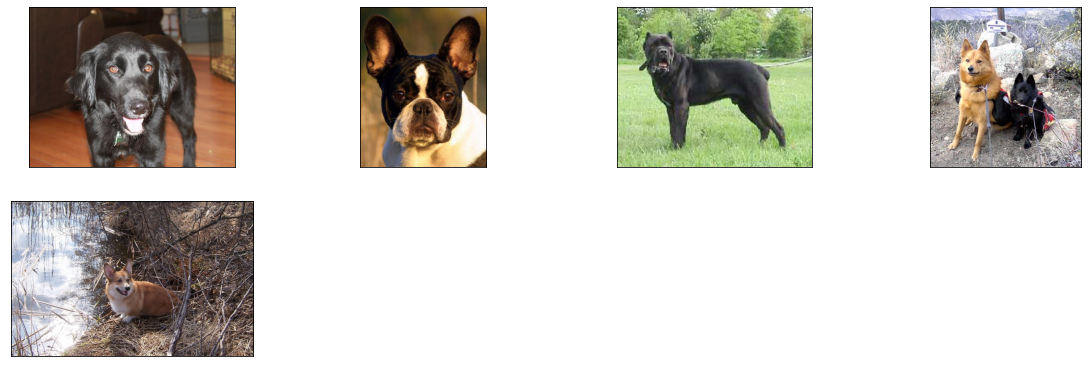

In [15]:
#Visualize some training examples

def displayImage(img_path,ax):
  image = cv2.imread(img_path)
  ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

sample = list(np.random.choice(train_files.shape[0],5))
fig = plt.figure(figsize=(20,10))
for index,im in enumerate(sample):
  ax = fig.add_subplot(3,4,index+1,xticks=[], yticks=[])
  displayImage(train_files[im],ax)

In [0]:

def createdatasets(dataset):
  data_set = np.zeros([dataset.shape[0],299,299,3])
  for i,image_arr in enumerate(dataset):
    img = cv2.imread(image_arr)
    res = cv2.resize(img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
    data_set[i,:,:,:] = res
  return data_set


Now,import the pretrained model using Keras. We have to remove the last layer and as we are removing the last layer we have to provide the Input tensor also.

In [0]:
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization
from keras.models import Sequential

In [18]:
from keras.applications.xception import Xception
newinput = Input(shape=(299,299,3))
model = Xception(include_top=False,input_tensor=newinput)
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

There is some processing required befor inputting the image to the model i.e., Feature Normalization. Keras takes care of that as well.

In [2]:
from keras.applications.xception import preprocess_input

Using TensorFlow backend.


In [0]:
#Setting all the layers to non-trainable, just in case
for layer in model.layers:
  layer.trainable = False


If we pass the images to the whole Model everytime during training then it will result in redundant computation. So instead of passing the images through the freezed layers everytime during training,we could pass all the images once and create what is called as Bottleneck and use that during training.

**Note: Running the cells below would consume a lot of memory, so I recommend you to run each cell seperately and after executing each cell wait for some time in order for RAM to refresh its state. Use google Colab if you don't have ~16Gb of RAM**

In [21]:
bottle_neck_test_set = model.predict(preprocess_input(createdatasets(test_files)),verbose=1)

836/836 [==============================] - 14s 17ms/step


In [22]:
bottle_neck_train_set = model.predict(preprocess_input(createdatasets(train_files)),verbose=1)

6680/6680 [==============================] - 57s 8ms/step


In [23]:
bottle_neck_valid_set = model.predict(preprocess_input(createdatasets(valid_files)),verbose=1)

835/835 [==============================] - 7s 9ms/step


Now, Define the last layer of the model.

In [0]:
from keras.layers import GlobalAveragePooling2D

model1=Sequential()


model1.add(GlobalAveragePooling2D(input_shape=(10,10,2048)))

model1.add(Dense(133,activation='softmax'))

In [41]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint
chkp = ModelCheckpoint("dogbreed.models.best.hdf5",verbose=1,save_best_only=True)

In [44]:
print(bottle_neck_train_set.shape)
print(train_targets.shape)
print(bottle_neck_valid_set.shape)
print(valid_targets.shape)

(6680, 10, 10, 2048)
(6680, 133)
(835, 10, 10, 2048)
(835, 133)


In [0]:
model1.fit(bottle_neck_train_set,train_targets,
          batch_size=64,epochs=50,verbose=1,
          callbacks=[chkp],validation_data=(bottle_neck_valid_set,valid_targets),shuffle=True)

In [91]:
import numpy as np
model1.load_weights("dogbreed.models.best.hdf5")
_pred = np.argmax(model1.predict(bottle_neck_test_set,verbose=1),axis=1)
original_pred = np.argmax(test_targets,axis=1)

836/836 [==============================] - 0s 358us/step


In [92]:
true=[]
for index in range(len(_pred)):
      if(original_pred[index]==_pred[index]):
          true.append(1)
      else:
        true.append(0)
print("Test Set Accuracy {}%".format((sum(true)/len(true))*100))

Test Set Accuracy 86.48325358851675%


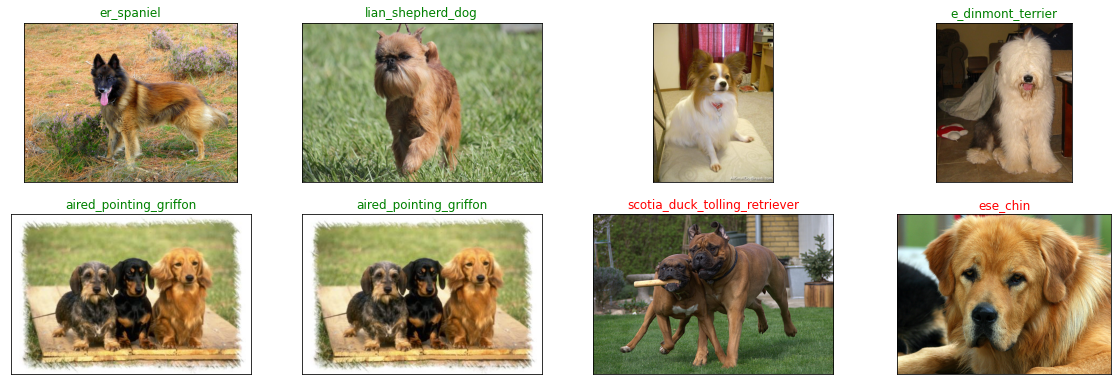

In [93]:
# Visualizing some Predictions
sample = np.random.choice(len(_pred),size=8)
figure=plt.figure(figsize=(20,10))
for i,im in enumerate(sample):
  ax = figure.add_subplot(3,4,i+1,xticks=[],yticks=[])
  image = cv2.imread(test_files[im])
  ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  ax.set_title('untitled' if dog_names[_pred[im]] == [] else dog_names[_pred[im]]  ,color = 'green' if _pred[im]==original_pred[im] else 'red')

# Using ResNet152V2

In [0]:
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization
from keras.models import Sequential

In [0]:
input_ = Input(shape=(224,224,3))
model = ResNet152V2(include_top=False,weights='imagenet',input_tensor=input_)
model.summary()
#I have cleared the output, because the model was too+++ deep and you would have to scroll for some time . 

In [0]:
def createdatasets_resnet(dataset):
  data_set = np.zeros([dataset.shape[0],224,224,3])
  for i,image_arr in enumerate(dataset):
    img = cv2.imread(image_arr)
    res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    data_set[i,:,:,:] = res
  return data_set

In [18]:
bottle_neck_train = model.predict(preprocess_input(createdatasets_resnet(train_files)),verbose=1)

6680/6680 [==============================] - 55s 8ms/step


In [19]:
bottle_neck_test =  model.predict(preprocess_input(createdatasets_resnet(test_files)),verbose=1)

836/836 [==============================] - 6s 8ms/step


In [20]:
bottle_neck_valid = model.predict(preprocess_input(createdatasets_resnet(valid_files)),verbose=1)

835/835 [==============================] - 6s 8ms/step


In [21]:
#Let's see what we got
print(bottle_neck_train.shape)
print(train_targets.shape)
print(bottle_neck_valid.shape)
print(valid_targets.shape)


(6680, 7, 7, 2048)
(6680, 133)
(835, 7, 7, 2048)
(835, 133)


**Note: ResNet152v2 model is ver powerful. If you directly apply softmax after this output to make predictions, it will overfit to the training_set in no time.**</br>
Therefore, I had to add another layer before applying softmax and using a large dropout so that the model could learn some representations instead of remembering the training set.

In [77]:
#Now Finetuning using this model
from keras.layers import GlobalAveragePooling2D

model1 = Sequential()

model1.add(GlobalAveragePooling2D(input_shape=(7,7,2048)))
model1.add(BatchNormalization())

model1.add(Dense(512,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.9))

model1.add(Dense(133,activation='softmax'))

model1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_10  (None, 2048)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 133)               68229     
Total params: 1,127,557
Trainable params: 1,122,437
Non-trainable params: 5,120
_______________________________________

In [0]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
from keras.callbacks import ModelCheckpoint
chkp = ModelCheckpoint('resnet.models.best.hdf5',save_best_only=True,verbose=1)


In [0]:
#model1.load_weights('resnet.models.best.hdf5')

In [0]:
model1.fit(bottle_neck_train,train_targets,verbose=1,epochs=100,
           batch_size=64,callbacks=[chkp],validation_data=(bottle_neck_valid,valid_targets),shuffle=True)

Even though I used very large dropout, the model still managed to somehow overfit the training_set and achieving about 91% accuracy on the training_set. After 50 epochs, the model managed to achieve ~82% accuracy on the validation set. I tried using differnet techniques to achieve better results but only this architecture managed to get 82% accuracy. 
**Here is a quick review:-**</br>
[Note every architecture includes the first GlobalAveragePooling layer]
- No Hidden Layer :
      Accuracy [Trainig Set : ~99.8% , Validation Set: ~67%]
- One Hidden Layer, No Dropout
      Accuracy [Trainig Set : ~99.8% , Validation Set: ~63%]
- One Hidden Layer, Dropout rate = 0.5
      Accuracy [Trainig Set : ~99.0% , Validation Set: ~74%]
- One Hidden Layer, Dropout rate = 0.8
      Accuracy [Trainig Set : ~97.0% , Validation Set: ~81%]
- One Hidden Layer, Dropout rate = 0.9
      Accuracy [Trainig Set : ~91.0% , Validation Set: ~82%]
- Two Hidden Layers, Dropout rate = 0.9 each</br>
    I had to train the model for quite a long time[about 700 epochs] but  the model seemed to be stuck at the same accuracy. Maybe for training about 5000-10,000 epochs, we can see better results. But I am not quite sure.
      Accuracy [Trainig Set : ~75.0% , Validation Set: ~71%]
- Two Hidden Layers, Dropout rate = 0.8 each  
      Accuracy [Trainig Set : ~79.0% , Validation Set: ~70%]
      I did not try to lower the dropout because you can clearly see where the model is headed. Overfitting!

Note: There are different configurations you can try, this is hyperparameter tuning and there is no rule for this. You can always try different hyperparameters.

In [82]:
import numpy as np
model1.load_weights("resnet.models.best.hdf5")
_pred = np.argmax(model1.predict(bottle_neck_test,verbose=1),axis=1)
original_pred = np.argmax(test_targets,axis=1)

836/836 [==============================] - 0s 238us/step


In [83]:
true=[]
for index in range(len(_pred)):
      if(original_pred[index]==_pred[index]):
          true.append(1)
      else:
        true.append(0)
print("Test Set Accuracy {}%".format((sum(true)/len(true))*100))

Test Set Accuracy 80.14354066985646%


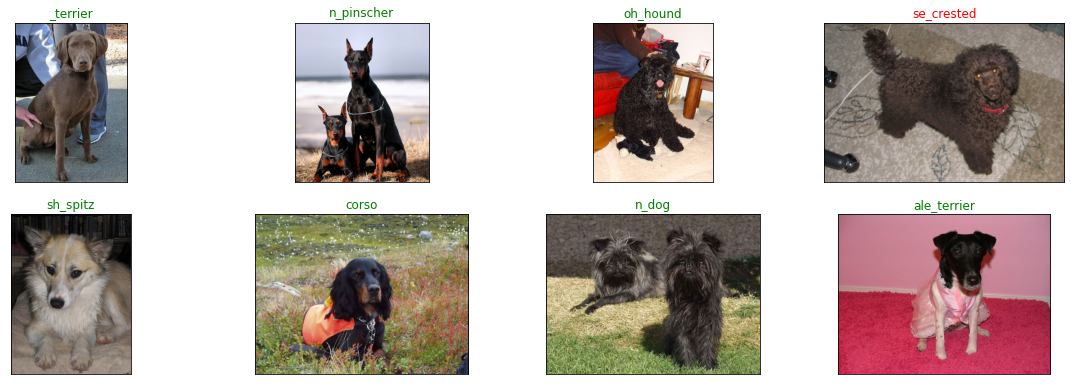

In [84]:
# Visualizing some Predictions
sample = np.random.choice(len(_pred),size=8)
figure=plt.figure(figsize=(20,10))
for i,im in enumerate(sample):
  ax = figure.add_subplot(3,4,i+1,xticks=[],yticks=[])
  image = cv2.imread(test_files[im])
  ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  ax.set_title('untitled' if dog_names[_pred[im]] == [] else dog_names[_pred[im]]  ,color = 'green' if _pred[im]==original_pred[im] else 'red')

# Conclusion:-
Clearly the Xception model was better in this case. The reason is quite obvious, Overfitting!</br>
ResNet152v2 is very deep model and as we do not have a large dataset, the model would easily overfit to the dataset.
</br>
So,model `[using transfering learning on]` Xception is better by about 6% accuracy on training set.

ResNet152v2 : ``~80% accuracy on test set.``
</br>
Xception    : ``~86% accuracy on test set``

